# Tutorial: ECT for Embedded Cell Complexes

This tutorial will walk you through using the `ECT` package. Particularly we will show the features of `EmbeddedComplex` class for computing the Euler Characteristic Transform on complexes with arbitrary dimensional cells.

The `EmbeddedComplex` class combines and extends the functionality of the previous `EmbeddedGraph` and `EmbeddedCW` classes, supporting:
- **0-cells** (vertices) with embedded coordinates
- **1-cells** (edges)
- **k-cells** for k ≥ 2 (faces, volumes, and higher-dimensional cells).



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ect import EmbeddedComplex, ECT, Directions
from ect.utils.examples import create_example_graph, create_example_cw, create_example_3d_complex

## Basic Usage: Creating Simple Complexes

### Example 1: Graph (1-skeleton)

Let's start with a simple triangle graph (for legacy users this can be equivalently done using `EmbeddedGraph`). 

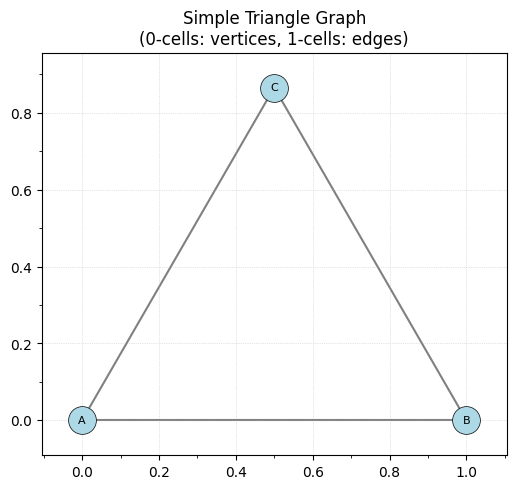

Number of nodes: 3
Number of edges: 3
Embedding dimension: 2


In [ ]:
K = EmbeddedComplex()

K.add_node('A', [0, 0])
K.add_node('B', [1, 0])
K.add_node('C', [0.5, 0.866])

K.add_edge('A', 'B')
K.add_edge('B', 'C')
K.add_edge('C', 'A')

#using built-in plotting function along with matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
K.plot(ax=ax, with_labels=True, node_size=400)
ax.set_title('Simple Triangle Graph\n(0-cells: vertices, 1-cells: edges)')
plt.show()

#print some information about the complex
print(f"Number of nodes: {len(K.nodes())}")
print(f"Number of edges: {len(K.edges())}")
print(f"Embedding dimension: {K.dim}")

Now let's add a 2-cell (face) to fill in the triangle:

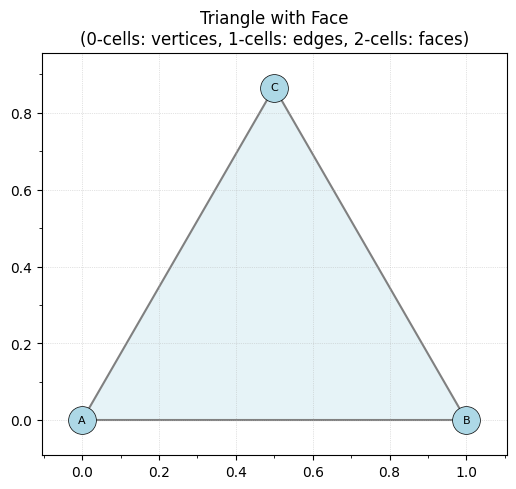

Number of 2-cells (faces): 1
Faces: [('A', 'B', 'C')]
Internal cells dictionary: {2: [(0, 1, 2)]}


In [ ]:
K.add_face(['A', 'B', 'C'])

fig, ax = plt.subplots(figsize=(6, 6))
K.plot(ax=ax, with_labels=True, node_size=400, face_alpha=0.3, face_color='lightblue')
ax.set_title('Triangle with Face\n(0-cells: vertices, 1-cells: edges, 2-cells: faces)')
plt.show()

print(f"Number of 2-cells (faces): {len(K.faces)}")
print(f"Faces: {K.faces}")
print(f"Internal cells dictionary: {dict(K.cells)}")

## Adding Cells of Arbitrary Dimension

The key new feature is the ability to add cells of any dimension:

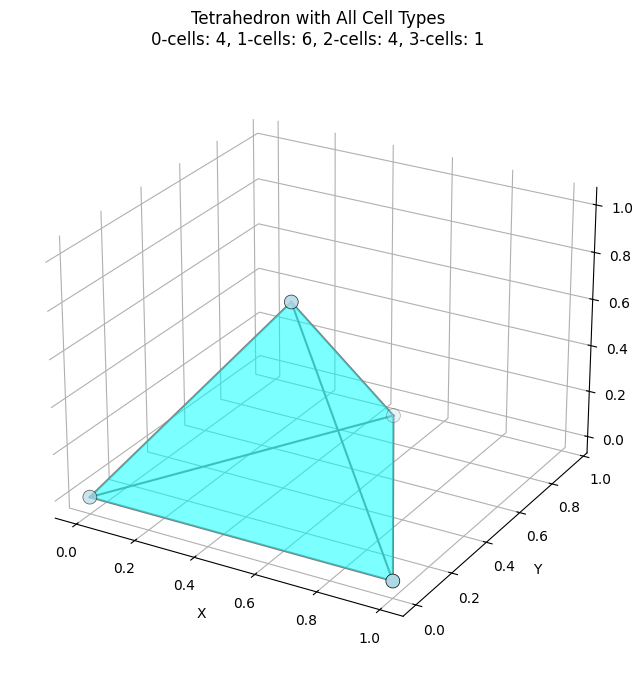

Dimension 2: 4 cells
Dimension 3: 1 cells

Total embedding dimension: 3


In [18]:
# Create a 3D tetrahedron with 0, 1, 2, and 3-cells
K_tetra = EmbeddedComplex()

# Add vertices (0-cells)
vertices = {
    'A': [0, 0, 0],
    'B': [1, 0, 0],
    'C': [0.5, 0.866, 0],
    'D': [0.5, 0.289, 0.816]  
}

for name, coord in vertices.items():
    K_tetra.add_node(name, coord)

# Add edges (1-cells) - all pairs
edges = [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
K_tetra.add_edges_from(edges)

# Add faces (2-cells) - all triangular faces
faces = [['A', 'B', 'C'], ['A', 'B', 'D'], ['A', 'C', 'D'], ['B', 'C', 'D']]
for face in faces:
    K_tetra.add_cell(face, dim=2)  # Explicitly specify dimension

# Add volume (3-cell) - the entire tetrahedron
K_tetra.add_cell(['A', 'B', 'C', 'D'], dim=3)

# Plot the tetrahedron
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
K_tetra.plot(ax=ax, face_alpha=0.3, face_color='cyan', node_size=100)
ax.set_title('Tetrahedron with All Cell Types\n0-cells: 4, 1-cells: 6, 2-cells: 4, 3-cells: 1')
plt.show()

# Display cell counts
for dim in sorted(K_tetra.cells.keys()):
    print(f"Dimension {dim}: {len(K_tetra.cells[dim])} cells")
    
print(f"\nTotal embedding dimension: {K_tetra.dim}")

## ECT Computation with Higher-Dimensional Cells

The ECT computation now properly includes all cell dimensions in the Euler characteristic calculation:

**χ = Σ(-1)^k × |k-cells below threshold|**

Let's see how this works:

ECT result shape: (8, 20)
Directions: 8 directions in 3D
Thresholds: 20 threshold values


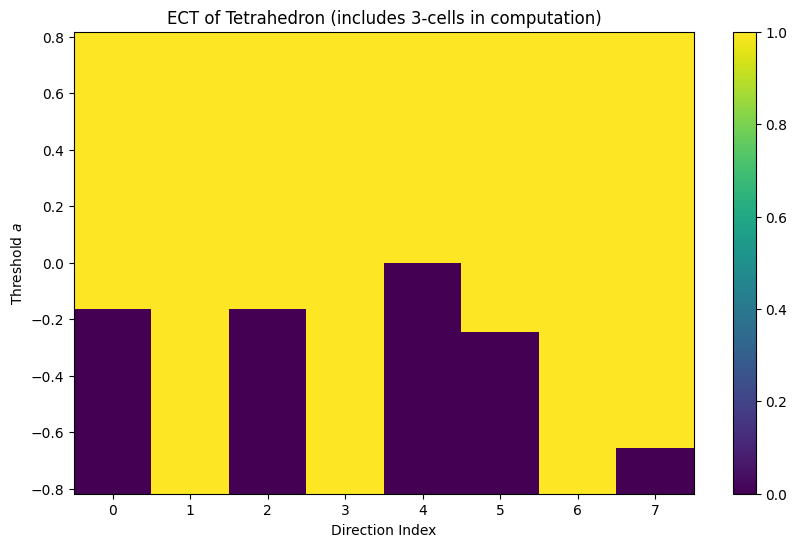

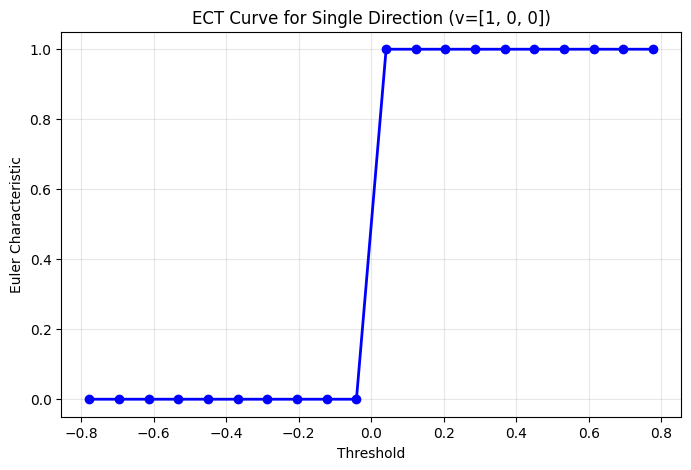

In [12]:
# Compute ECT for the tetrahedron
ect = ECT(num_dirs=8, num_thresh=20)
result = ect.calculate(K_tetra)

print(f"ECT result shape: {result.shape}")
print(f"Directions: {len(result.directions)} directions in {K_tetra.dim}D")
print(f"Thresholds: {len(result.thresholds)} threshold values")

# Plot the ECT matrix
fig, ax = plt.subplots(figsize=(10, 6))
result.plot()
plt.title('ECT of Tetrahedron (includes 3-cells in computation)')
plt.show()

# Show a single direction

single_direction = ECT(num_thresh=20, directions=Directions.from_vectors([[1, 0, 0]])).calculate(K_tetra)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(single_direction.thresholds, single_direction[0], 'b-', marker='o', linewidth=2)
ax.set_xlabel('Threshold')
ax.set_ylabel('Euler Characteristic')
ax.set_title('ECT Curve for Single Direction (v=[1, 0, 0])')
ax.grid(True, alpha=0.3)
plt.show()

You can also restrict self-intersections by using the 'validate_embeddings' argument. Currently without checks we can add a node inside of our tetrahedron.

In [26]:
K_valid = K_tetra.copy()

K_valid.add_node('E', [0.5, 0.289, 0.204])
K_valid.add_cell(['E', 'B'], dim=1)



# Display cell counts
print("4D Simplex Cell Counts:")
for dim in sorted(K_valid.cells.keys()):
    print(f"  {dim}-cells: {len(K_valid.cells[dim])}")

# Plot (showing 3D projection)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
K_valid.plot(ax=ax, face_alpha=0.1, node_size=80)
ax.set_title('4D Simplex (5 vertices, cells up to dimension 4)')
plt.show()

# Compute ECT
ect_4d = ECT(num_dirs=6, num_thresh=15)
result_4d = ect_4d.calculate(K_valid)

fig, ax = plt.subplots(figsize=(10, 6))
result_4d.plot()
plt.title('ECT of 4D Simplex\n(alternating sum includes all dimensions 0-4)')
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/yayub/miniconda3/envs/dataexp/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/81/3x5xj5kx4ys30p1c2z55bhbw0000gn/T/ipykernel_80902/4266954845.py", line 1, in <module>
    K_valid = K_tetra.copy()
              ^^^^^^^^^^^^^^
  File "/Users/yayub/miniconda3/envs/dataexp/lib/python3.11/site-packages/networkx/classes/graph.py", line 1642, in copy
    G.add_nodes_from((n, d.copy()) for n, d in self._node.items())
  File "/Users/yayub/Code/ect/src/ect/embed_complex.py", line 177, in add_nodes_from
  File "/Users/yayub/Code/ect/src/ect/embed_complex.py", line 120, in wrapper
    )
      
  File "/Users/yayub/Code/ect/src/ect/embed_complex.py", line 142, in wrapper
    def wrapper(self, *args, **kwargs):
               ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yayub/Code/ect/src/ect/embed_complex.py", line 157, in add_node
    return

## Understanding ECT with Projection Visualization

Let's visualize how the ECT computation works by showing projection values:

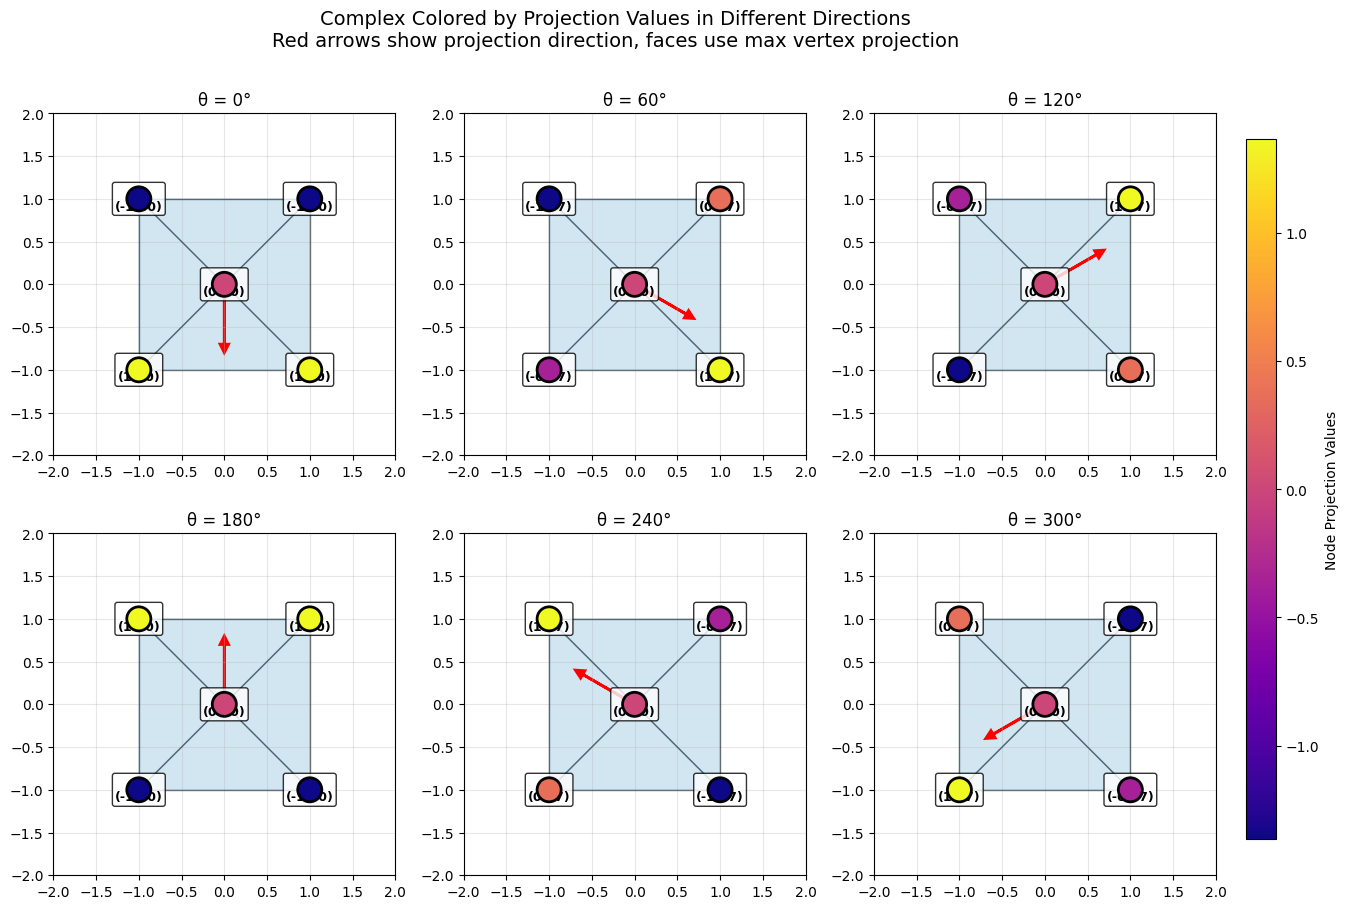

In [7]:
# Create a simple 2D example for visualization
K_viz = EmbeddedComplex()

# Square with center point
K_viz.add_node('A', [-1, -1])
K_viz.add_node('B', [1, -1])
K_viz.add_node('C', [1, 1])
K_viz.add_node('D', [-1, 1])
K_viz.add_node('E', [0, 0])  # center

# Add edges
edges = [('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'A'),  # boundary
         ('A', 'E'), ('B', 'E'), ('C', 'E'), ('D', 'E')]   # to center
K_viz.add_edges_from(edges)

# Add triangular faces
faces = [['A', 'B', 'E'], ['B', 'C', 'E'], ['C', 'D', 'E'], ['D', 'A', 'E']]
for face in faces:
    K_viz.add_face(face)

# Visualization function
def plot_with_projections(K, theta, ax):
    """Plot complex with nodes colored by projection values"""
    direction = np.array([np.sin(theta), -np.cos(theta)])
    node_projections = np.dot(K.coord_matrix, direction)
    
    # Plot edges
    for u, v in K.edges():
        u_idx = K.node_to_index[u]
        v_idx = K.node_to_index[v]
        x = [K.coord_matrix[u_idx, 0], K.coord_matrix[v_idx, 0]]
        y = [K.coord_matrix[u_idx, 1], K.coord_matrix[v_idx, 1]]
        ax.plot(x, y, 'k-', alpha=0.5, linewidth=1)
    
    # Plot faces with transparency
    for face_indices in K.cells.get(2, []):
        face_coords = K.coord_matrix[list(face_indices)]
        face_projection = np.max(node_projections[list(face_indices)])
        ax.fill(face_coords[:, 0], face_coords[:, 1], 
               alpha=0.3, color=plt.cm.Blues(0.5))
    
    # Plot nodes colored by projection
    scatter = ax.scatter(K.coord_matrix[:, 0], K.coord_matrix[:, 1], 
                        c=node_projections, cmap='plasma', s=300, 
                        edgecolors='black', linewidth=2, zorder=10)
    
    # Add node labels with projection values
    for i, node in enumerate(K.node_list):
        ax.annotate(f'{node}\n({node_projections[i]:.2f})', 
                   (K.coord_matrix[i, 0], K.coord_matrix[i, 1]),
                   ha='center', va='center', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    # Direction arrow
    ax.arrow(0, 0, direction[0]*0.7, direction[1]*0.7,
             head_width=0.1, head_length=0.1, fc='red', ec='red', linewidth=2)
    
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'θ = {theta*180/np.pi:.0f}°')
    
    return scatter

# Show projections in multiple directions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

thetas = np.linspace(0, 2*np.pi, 6, endpoint=False)
for ax, theta in zip(axes, thetas):
    scatter = plot_with_projections(K_viz, theta, ax)

# Add shared colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(scatter, cax=cbar_ax, label='Node Projection Values')

plt.suptitle('Complex Colored by Projection Values in Different Directions\n' + 
            'Red arrows show projection direction, faces use max vertex projection', 
            fontsize=14)
plt.show()

## Comparing Graph vs. Complex ECT

Let's compare ECT results for the same geometry with and without 2-cells:

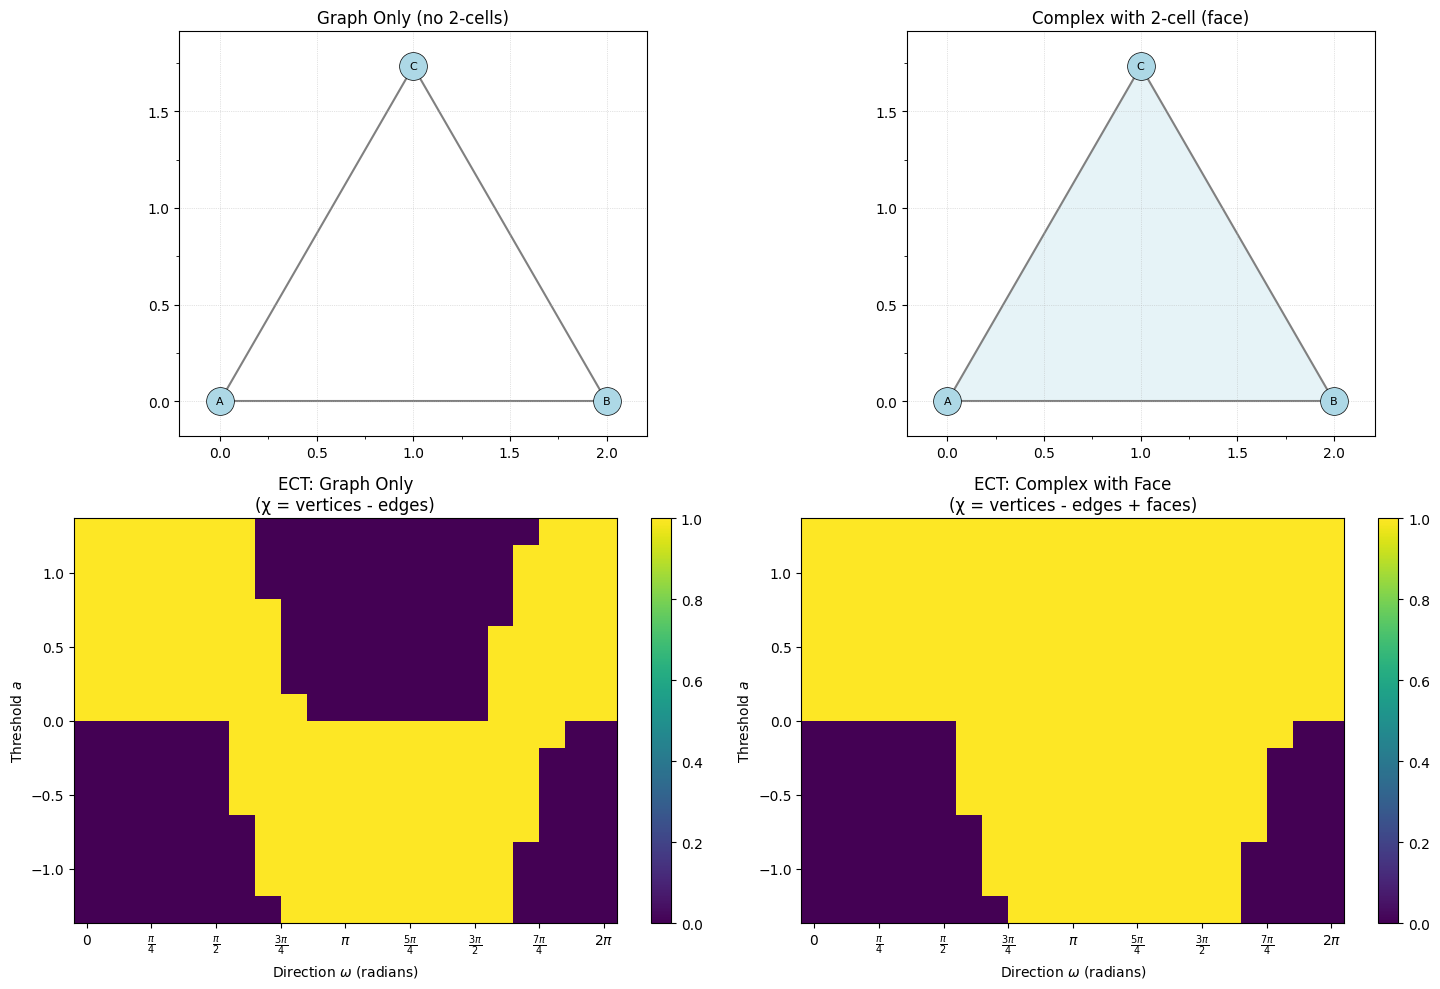

ECT value ranges:
Graph only: [0, 1]
With face:  [0, 1]

The face contributes +1 to the Euler characteristic when included.


In [8]:
# Create two versions: graph only vs. complex with faces
K_graph = EmbeddedComplex()
K_complex = EmbeddedComplex()

# Same vertices and edges for both
vertices = {'A': [0, 0], 'B': [2, 0], 'C': [1, 1.732]}
edges = [('A', 'B'), ('B', 'C'), ('C', 'A')]

for K in [K_graph, K_complex]:
    for name, coord in vertices.items():
        K.add_node(name, coord)
    K.add_edges_from(edges)

# Add face only to the complex version
K_complex.add_face(['A', 'B', 'C'])

# Compute ECT for both
ect = ECT(num_dirs=20, num_thresh=30)
result_graph = ect.calculate(K_graph)
result_complex = ect.calculate(K_complex)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Visualizations
K_graph.plot(ax=axes[0,0], with_labels=True, node_size=400)
axes[0,0].set_title('Graph Only (no 2-cells)')

K_complex.plot(ax=axes[0,1], with_labels=True, node_size=400, 
               face_alpha=0.3, face_color='lightblue')
axes[0,1].set_title('Complex with 2-cell (face)')

# ECT comparisons
result_graph.plot(ax=axes[1,0])
axes[1,0].set_title('ECT: Graph Only\n(χ = vertices - edges)')

result_complex.plot(ax=axes[1,1])
axes[1,1].set_title('ECT: Complex with Face\n(χ = vertices - edges + faces)')

plt.tight_layout()
plt.show()

# Show numerical difference
print("ECT value ranges:")
print(f"Graph only: [{result_graph.min()}, {result_graph.max()}]")
print(f"With face:  [{result_complex.min()}, {result_complex.max()}]")
print(f"\nThe face contributes +1 to the Euler characteristic when included.")